# Introduction

This Jupyter Notebook has the objective to create a Neural Network model that can predict if the person has diabetes.

## Libraries used

For this challenge I have used:

- tensorflow
- keras
- numpy
- pandas
- scikit-learn
- scikit-plot

# The code!

## Importing the dataset

To begin let's import the dataset into a panda's dataframe and creating the X and y tables.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

RS=0

df = pd.read_csv("diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

## Formatting the data

This part is one of the most important parts, that's because neural networks works better with values between 0 and 1. So we will format the data.

But before that let's take a look at the details of the dataframe:

In [2]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


So every feature has values above 1 and that's a problem, so let's format it:

In [3]:
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

X.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.63953,0.847771,0.149543,0.906679,-0.692439,0.20388,0.468187,1.425067


Now all values are between 0 and 1 and we can start making our model.

## Making the structure model

Now we can create the structure of the neural network, in this example we will use the following structure:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(12, input_dim=8, activation="relu"),
    Dropout(rate=0.4),
    Dense(36, activation="relu"),
    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                468       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 37        
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________


Above you can se more details about the structure...

A Dropout function has been used so we pick random neurons of the layer that comes after it has been called.

## Splitting the data

To train the model we need to split the data so we can get a better result.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=RS)

Now that we have the trainning and validation data we can train it.

## Training the model

To train the data we will use WarlyStopping function that will stop the training as soon as the overfitting starts.

<AxesSubplot:>

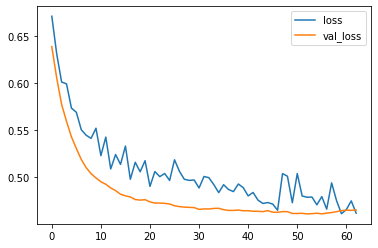

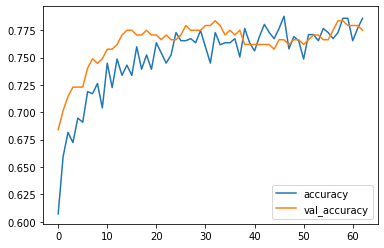

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.00005,
    restore_best_weights=True,
)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)

history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

By seeing this graphics we can be sure that there is almost no overfitting, and we have trained enough so we have passed the underfitting phase.

## Predicting diabetes

Let's predict using the validation data:

In [7]:
preds = model.predict(X_valid)
for pred in preds:
    if pred[0] >= 0.5:
        pred[0] = 1
    else:
        pred[0] = 0

After the prediction you will have an array with values between 0 and 1 so we need to get values above of 0.5 and consider they are 1 and lower than 0.5 we change to 0. That way we can plot a confusion matrix :)

## Checking the predictions

Accuracy: 70.98%
Precision: 67.8%
Recall: 54.05%
F1 score: 60.15%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

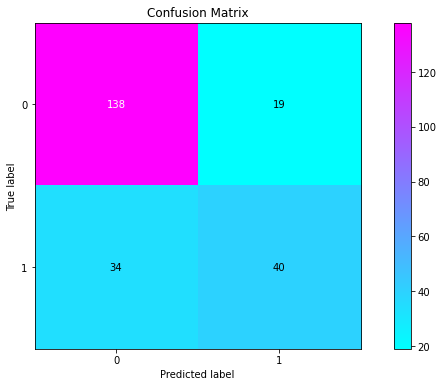

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
import scikitplot as skplt

print("Accuracy: " + str(round(balanced_accuracy_score(y_valid, preds)*100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_valid, preds, average='binary')*100, 2)) + "%")
print("Recall: " + str(round(recall_score(y_valid, preds, average='binary')*100, 2)) + "%")
print("F1 score: " + str(round(f1_score(y_valid, preds, average='binary')*100, 2)) + "%")

skplt.metrics.plot_confusion_matrix(
    y_valid, 
    preds,
    figsize=(12,6),
    cmap="cool",
)

Confusion matrix is a great way to display the results, because it shows our True Positives and Negatives and the False Positives and Negatives.